In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Đọc file dữ liệu
df = pd.read_csv('Gold.csv')
df.head(5)

,Date,Open,Close,High,Low
0,3/26/2024,2172.68,2179.12,2199.88,2167.97
1,3/25/2024,2166.82,2172.30,2181.00,2163.97
2,3/24/2024,0.00,2165.99,2167.89,2165.30
3,3/23/2024,2165.40,2165.40,2165.40,2165.40
4,3/22/2024,2181.34,2165.40,2186.05,2157.45


In [3]:
df.describe()

,Open,Close,High,Low
count,1694.000000,1694.000000,1694.000000,1694.000000
mean,1740.718772,1780.637338,1774.244410,1751.894345
std,325.955267,197.721215,255.848268,267.536718
min,0.000000,1270.650000,0.000000,0.000000
25%,1691.637500,1708.035000,1714.262500,1691.597500
50%,1808.650000,1811.180000,1817.715000,1802.475000
75%,1921.700000,1923.600000,1930.730000,1913.552500
max,2198.650000,2202.200000,2211.700000,2177.850000


In [4]:
df.loc[0,:]

Date     3/26/2024
Open       2172.68
Close      2179.12
High       2199.88
Low        2167.97
Name: 0, dtype: object

In [5]:
# Đưa về kiểu date và đánh index
df['Date'] = pd.to_datetime(df.Date)

# Sắp xếp lại index
df = df.sort_index(ascending=False)
df

,Date,Open,Close,High,Low
1693,2019-03-01,1314.460,1292.765,1315.105,1290.355
1692,2019-03-02,1292.765,1292.765,1292.765,1292.765
1691,2019-03-03,1292.765,1292.765,1292.765,1292.765
1690,2019-03-04,1295.910,1286.710,1297.105,1283.160
1689,2019-03-05,1287.410,1287.775,1289.550,1281.460
...,...,...,...,...,...
4,2024-03-22,2181.340,2165.400,2186.050,2157.450
3,2024-03-23,2165.400,2165.400,2165.400,2165.400
2,2024-03-24,0.000,2165.990,2167.890,2165.300
1,2024-03-25,2166.820,2172.300,2181.000,2163.970


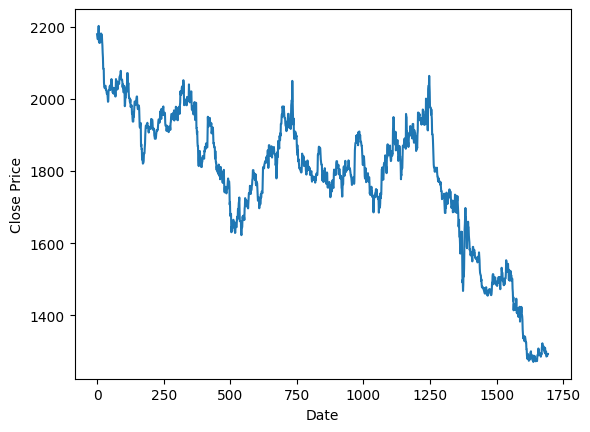

In [6]:
# Vẽ biểu đồ chuỗi thời gian
plt.plot(df.index, df["Close"])
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [7]:
df = df[['Close']]
df = df.reset_index(drop=True)
df.head(5)

,Close
0,1292.765
1,1292.765
2,1292.765
3,1286.710
4,1287.775


In [8]:
#Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [9]:
# Chia train test theo tỉ lệ 6:4
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(0.6 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [10]:
train_data

array([[0.02374   ],
       [0.02374   ],
       [0.02374   ],
       ...,
       [0.65777468],
       [0.62583866],
       [0.60946809]])

In [11]:
# Chuẩn bị dữ liệu cho x,y
def create_dataset(dataset, lags=1):
    X, Y = [], []
    for i in range(len(dataset)-lags-1):
        a = dataset[i:(i+lags), 0]
        X.append(a)
        Y.append(dataset[i + lags, 0])
    return np.array(X), np.array(Y)

In [12]:
#Thiết lập tham số cho model
lags = 30 
X_train, y_train = create_dataset(train_data, lags)
X_test, y_test = create_dataset(test_data, lags)

In [13]:
X_test

array([[0.62460415, 0.591702  , 0.58102088, ..., 0.62445387, 0.62552735,
        0.62006334],
       [0.591702  , 0.58102088, 0.54634749, ..., 0.62552735, 0.62006334,
        0.64495733],
       [0.58102088, 0.54634749, 0.54634749, ..., 0.62006334, 0.64495733,
        0.64495733],
       ...,
       [0.80933927, 0.82158768, 0.82158768, ..., 1.        , 0.97744619,
        0.96049595],
       [0.82158768, 0.82158768, 0.82158768, ..., 0.97744619, 0.96049595,
        0.96049595],
       [0.82158768, 0.82158768, 0.81653159, ..., 0.96049595, 0.96049595,
        0.9611293 ]])

In [14]:
#In thông tin kích thước của dữ liệu
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(985, 30) (985,)
(647, 30) (647,)


In [15]:
model = SVR()

# Thiết lập phạm vi tốt cho các tham số
C_range = [0.1, 1, 10]  # Thay đổi tại đây
gamma_range = [0.01, 0.1, 1]  # Thay đổi tại đây
kernel_range = ['rbf', 'poly', 'linear', 'sigmoid'] #tạo ra 3 giá trị cho kernel

# Tạo lưới các giá trị tham số
param_grid = {'C': C_range, 'gamma': gamma_range, 'kernel': kernel_range}

# Thiết lập model với các tham số và số lượng folds cross-validation
model = GridSearchCV(model, param_grid, refit=True, verbose=3, cv=5, scoring='neg_mean_squared_error')

#trong đó:
#clf: model
#param_grid: tham số
#refit: lưu lại model tốt nhất
#verbose: hiển thị thông tin
#cv: số lượng folds cross-validation (chọn 5 folds cross-validation)
#scoring: đánh giá model bằng MSE

#8. Huấn luyện model
model.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.018 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.006 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.003 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=0.01, kernel=poly;, score=-0.169 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.01, kernel=poly;, score=-0.026 total time=   0.0s
[CV 3/5] END ...C=0.1, gamma=0.01, kernel=poly;, score=-0.041 total time=   0.0s
[CV 4/5] END ...C=0.1, gamma=0.01, kernel=poly;, score=-0.008 total time=   0.0s
[CV 5/5] END ...C=0.1, gamma=0.01, kernel=poly;, score=-0.026 total time=   0.0s
[CV 1/5] END .C=0.1, gamma=0.01, kernel=linear;, score=-0.003 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=0.01, kernel=linear;

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1],
                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=3)

In [16]:
model.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}

In [17]:
#Dự báo dự liệu dựa trên tập test
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()

In [18]:
y_pred

array([1859.24525011, 1863.81399404, 1869.54513652, 1871.1437713 ,
       1855.57549326, 1845.97922771, 1846.62078222, 1853.25956574,
       1853.4854702 , 1850.79515635, 1854.37155018, 1856.32415745,
       1852.88311945, 1852.55323622, 1845.87826438, 1843.31150002,
       1844.47312041, 1842.43388679, 1839.60833352, 1836.14069353,
       1834.57924761, 1834.33455805, 1833.99491905, 1831.75501776,
       1828.66962145, 1827.65476483, 1812.67758244, 1796.41452081,
       1787.31248425, 1784.01101302, 1781.25723459, 1776.97741959,
       1773.38225559, 1772.71407772, 1763.20749791, 1757.18840357,
       1750.69648006, 1747.11006458, 1744.34779555, 1736.36839662,
       1739.19220655, 1739.9313716 , 1741.21140691, 1739.41807218,
       1737.40976731, 1741.70221387, 1746.94322429, 1752.09352848,
       1755.29095596, 1755.62505976, 1759.28944999, 1758.93777635,
       1758.41020581, 1767.98640264, 1766.86809382, 1767.7897856 ,
       1769.0413447 , 1775.07535983, 1779.92319134, 1781.53300

In [19]:
# 10. Đánh giá độ chính xác thuật toán bằng MAPE, MSE và RMSE

#MAPE
test_mape = mean_absolute_percentage_error(y_pred, y_test)
#MSE
test_mse = mean_squared_error(y_pred, y_test)
#RMSE
test_rmse = np.sqrt(test_mse)

print('Testing MAPE:', test_mape)
print('Testing MSE:', test_mse)
print('Testing RMSE:', test_rmse)

Testing MAPE: 0.9996498316513596
Testing MSE: 3634724.1138493842
Testing RMSE: 1906.4952435947446


In [20]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
lags=30
i=0
while(i<30):
    if(len(temp_input)>30):
        x_input=np.array(temp_input[-lags:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        yhat = model.predict(x_input)[0]  # Get the scalar value directly
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat)  # Append the scalar value directly
        temp_input=temp_input[1:]
        lst_output.append(yhat)  # Append the scalar value directly
        i=i+1
    else:
        x_input = x_input.reshape(1,-1)
        yhat = model.predict(x_input)[0]  # Get the scalar value directly
        print(yhat)
        temp_input.append(yhat)
        print(len(temp_input))
        lst_output.append(yhat)
        i=i+1


0 day input [0.81653159 0.81572648 0.82004187 0.83060491 0.87273898 0.87273898
 0.87273898 0.90585583 0.92034781 0.94217165 0.9547421  0.97386077
 0.97386077 0.97424722 0.9775106  0.9537867  0.97085503 0.95645966
 0.95031936 0.95031936 0.94927808 0.95587998 0.95312114 1.
 0.97744619 0.96049595 0.96049595 0.9611293  0.96790296 0.97522409]
0 day output 0.9719120365267658
1 day input [0.81572648 0.82004187 0.83060491 0.87273898 0.87273898 0.87273898
 0.90585583 0.92034781 0.94217165 0.9547421  0.97386077 0.97386077
 0.97424722 0.9775106  0.9537867  0.97085503 0.95645966 0.95031936
 0.95031936 0.94927808 0.95587998 0.95312114 1.         0.97744619
 0.96049595 0.96049595 0.9611293  0.96790296 0.97522409 0.97191204]
1 day output 0.9724869438899889
2 day input [0.82004187 0.83060491 0.87273898 0.87273898 0.87273898 0.90585583
 0.92034781 0.94217165 0.9547421  0.97386077 0.97386077 0.97424722
 0.9775106  0.9537867  0.97085503 0.95645966 0.95031936 0.95031936
 0.94927808 0.95587998 0.95312114 1

In [21]:
# Inverse transform the future predictions
lst_output = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)).flatten()

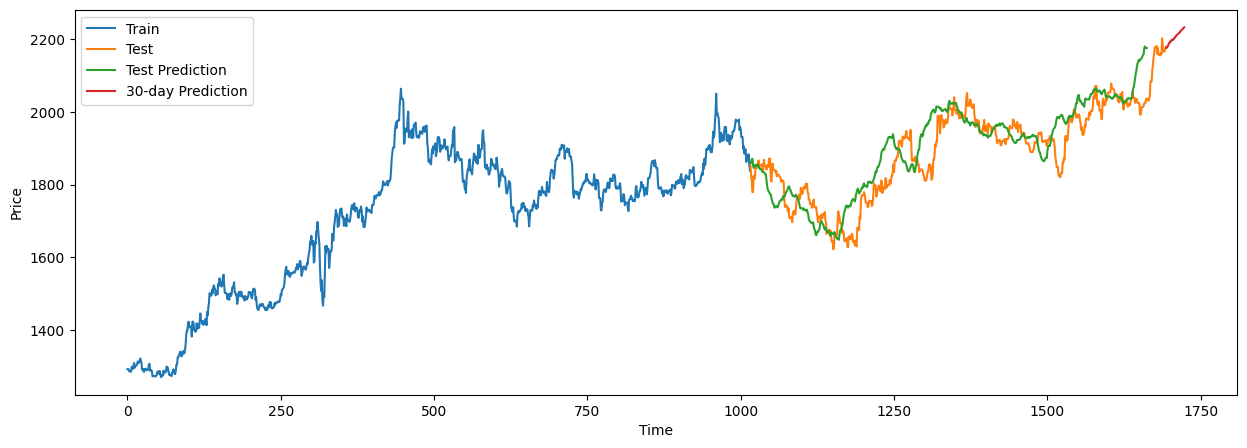

In [22]:
plt.figure(figsize=(15,5))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_pred_index = pd.RangeIndex(start=train_size, stop=train_size+len(y_pred), step=1)
plt.plot(test_pred_index, y_pred)

next_30days_pred_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+len(lst_output), step=1)
plt.plot(next_30days_pred_index, lst_output)

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(['Train', 'Test', 'Test Prediction', '30-day Prediction'])
plt.show()